## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# When submitting project, don't forget to delete/change or codes that is specifically for google colab

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


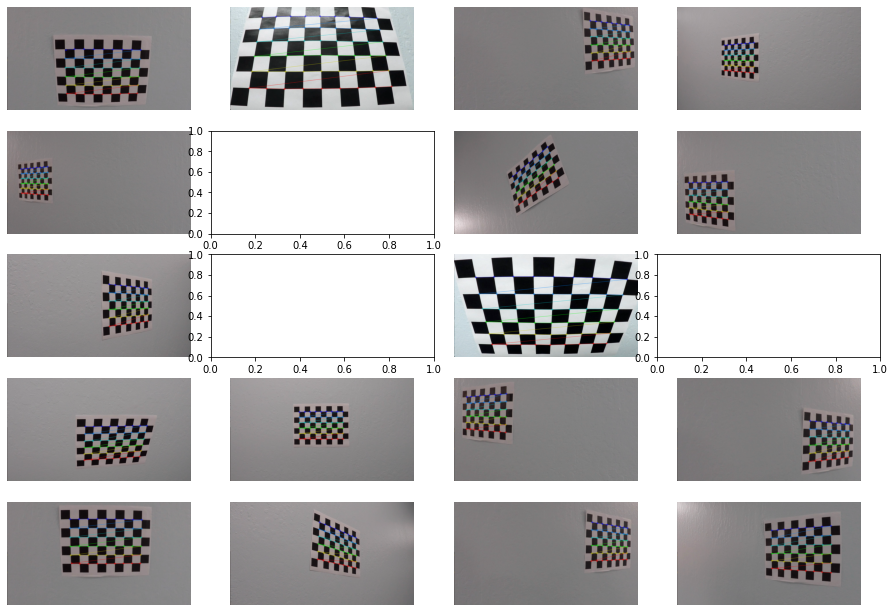

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
path = '/content/drive/My Drive/CarND-Advanced-Lane-Lines/'
os.chdir(path)
cal_images = glob.glob('./camera_cal/calibration*.jpg')


fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners

for i, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

some of these images do not appear because the specified number of chessboard corners were not found

# Distortion correction

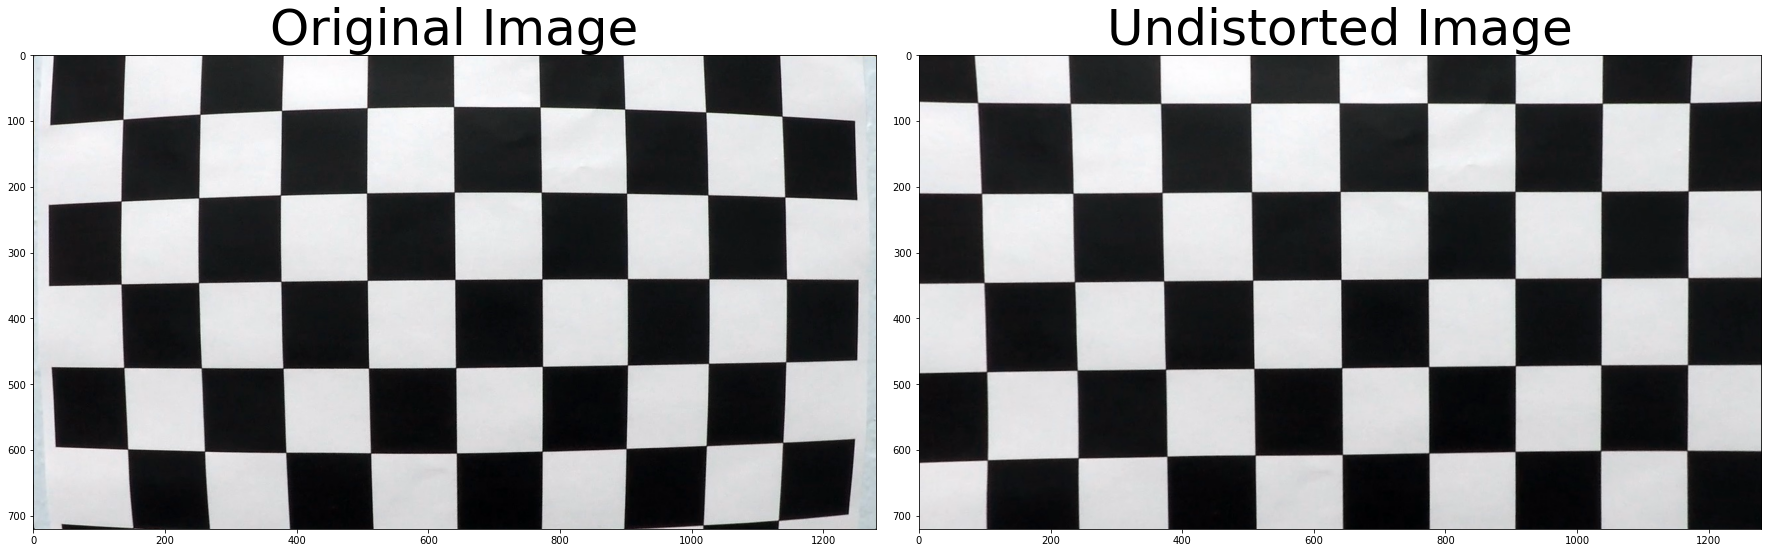

In [2]:
def cal_undistort(img,objpoints,imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

#test an example
img_example = cv2.imread(cal_images[9])
undistorted_example = cal_undistort(img_example,objpoints,imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_example)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_example)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Example of distortion-corrected image

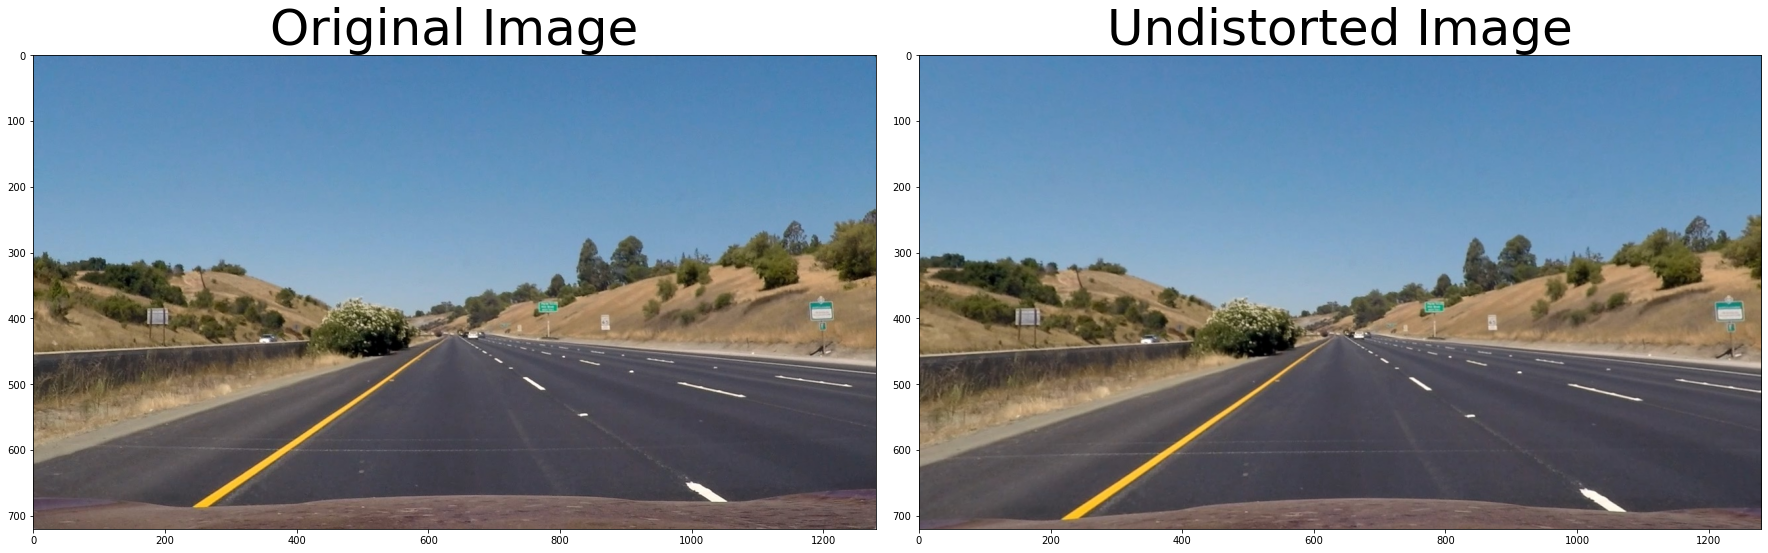

In [3]:
img_example2 = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
undistorted_example2 = cal_undistort(img_example2,objpoints,imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_example2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_example2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Create binary image

In [0]:
# Define region of interst. May not be necessary because the warp function did the similar thing
'''
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    '''


def binary(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
    img = np.copy(img)

    # Convert to HLS color space and select the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take the derivative in x. Notes: do remember to use gray here. If use colored image, it won't detect correctly when the road color changed
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9) 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary ==1) | (sxbinary ==1)] = 1

    '''   
    # Define region of interest
    vertices = np.array([[(100,img.shape[0]-20),(620,420),(750,450),(1200,img.shape[0]-20)]],dtype=np.int32)
    binary_output = region_of_interest(combined_binary,vertices)
    '''
    

    return combined_binary

## Binary image example

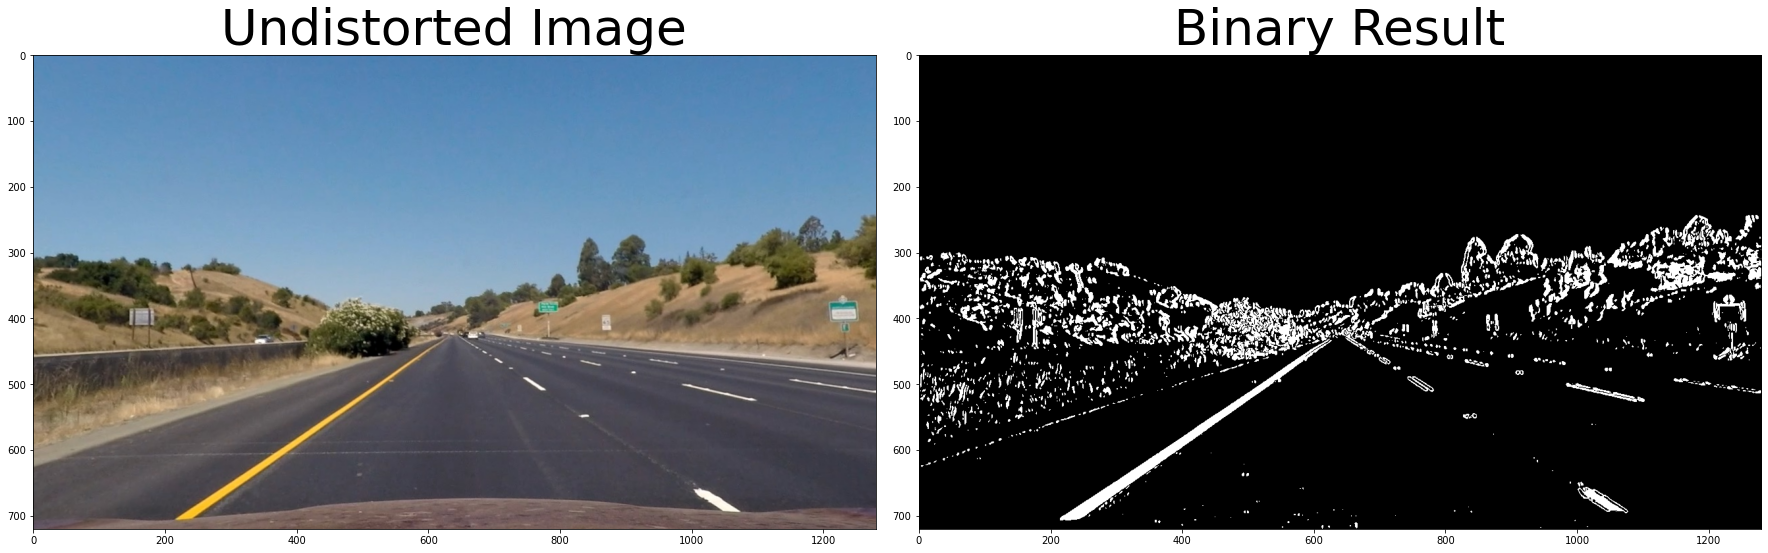

In [21]:
binary_example = binary(undistorted_example2)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_example2)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(binary_example, cmap='gray')
ax2.set_title('Binary Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

In [0]:
#Define perspective transform function
def warp(img, src, dst):
    
    #Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

## Example of transformed image

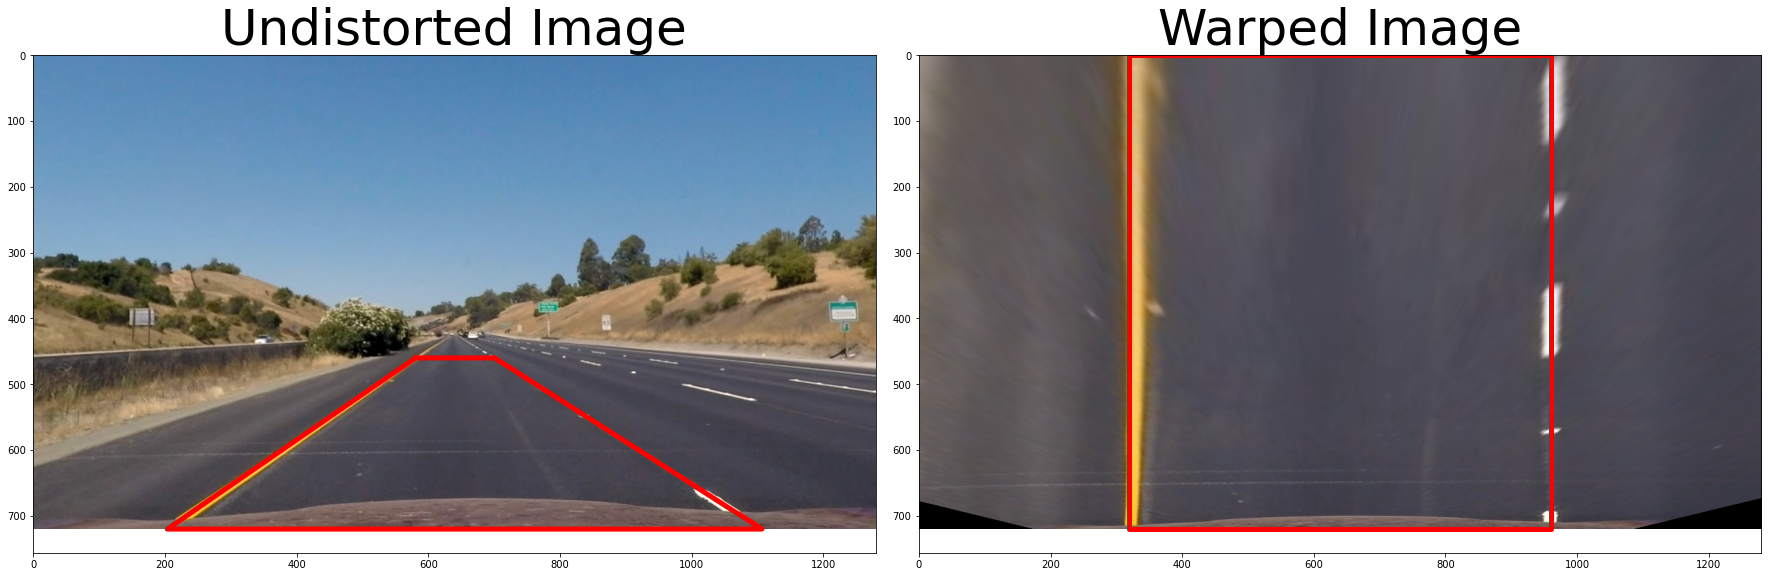

In [7]:
#Define source and destination points
w = undistorted_example2.shape[1]
h = undistorted_example2.shape[0]

src = np.float32(
    [[w/2-60, h/2+100],
      [w/6-10, h],
      [w*5/6+40, h],
      [w/2+60, h/2+100]]
    )

dst = np.float32(
    [[w/4, 0],
      [w/4, h],
      [w*3/4, h],
      [w*3/4, 0]]
    )

warp_example = warp(undistorted_example2, src, dst)

#repeat first point of src & dst to create a 'closed loop' in plot
src_draw = np.concatenate((src,[src[0]]))
dst_draw = np.concatenate((dst,[dst[0]]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_example2)
ax1.set_title('Undistorted Image', fontsize=50)
ax1.plot(src_draw[:,0], src_draw[:,1], c='r', linewidth=5.0)
ax2.imshow(warp_example)
ax2.set_title('Warped Image', fontsize=50)
ax2.plot(dst_draw[:,0], dst_draw[:,1], c='r', linewidth=5.0)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find lanes using sliding window

In [0]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def fitpoly_scratch(binary_warped):
    # Set the width of the windows +/- margin
    margin = 100
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # While it's dotted line, this is to avoid misplacing base due to dotted line not so clear
    leftx_base = np.argmax(histogram[100:midpoint]) + 100
    rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #Fit 2nd polynomial
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty

In [0]:
def fitpoly_prior(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #Fit 2nd polynomial
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx,2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Generate x and y values for plotting
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty

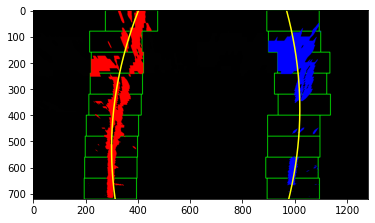

In [22]:
#example of fitted polynomial lines
img = cv2.cvtColor(cv2.imread('./test_images/test5.jpg'), cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img,objpoints,imgpoints)
binary_img = binary(undistorted)
binary_warped = warp(binary_img, src, dst)
out_img1, left_fit_example, right_fit_example = fitpoly_scratch(binary_warped)[0:3]
plt.imshow(out_img1)

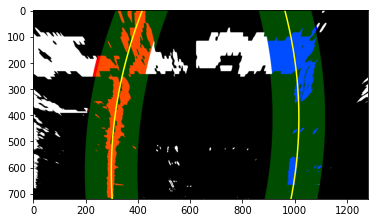

In [23]:
out_img2 = fitpoly_prior(binary_warped, left_fit_example, right_fit_example)[0]
plt.imshow(out_img2)

## Measure curvature

452.4657366730567 m 0.07135714285714286 m


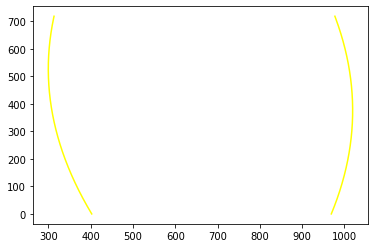

In [24]:
def measure_curvature(binary_warped, leftx, lefty, rightx, righty, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_curverad = (left_curverad + right_curverad) / 2.

    # Calculate position of car with respect to center of lane
    center_car = binary_warped.shape[1] / 2.
    center_lane = (leftx[0] + rightx[0]) / 2.
    position = (center_car - center_lane) * xm_per_pix

    return center_curverad, position, left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
leftx, lefty, rightx, righty, ploty = fitpoly_scratch(binary_warped)[5:]
center_curverad, position, left_curverad, right_curverad = measure_curvature(binary_warped, leftx, lefty, rightx, righty, ploty)

print(center_curverad, 'm', position, 'm')

## Draw lines back to the image

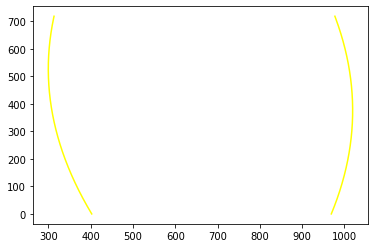

In [25]:
# Create an image to draw the lines on
def drawlines(binary_warped, undistorted, src, dst, left_fitx, right_fitx):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Fill the space between polylines
    cv2.fillPoly(color_warp, np.int_([pts]),(0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    # Add curvature & car position to image
    center_curverad, position, left_curverad, right_curverad = measure_curvature(binary_warped, leftx, lefty, rightx, righty, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255, 255, 255)
    cv2.putText(result, 'Curvature: {} m'.format(center_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} m of center'.format(position), (50, 120), font, fontScale, fontColor, 2)

    return result

left_fitx, right_fitx = fitpoly_scratch(binary_warped)[3:5]
result = drawlines(binary_warped, undistorted, src, dst, left_fitx, right_fitx)

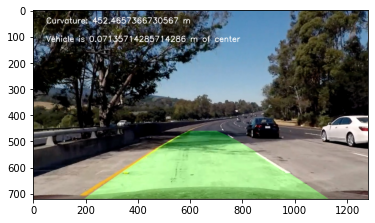

In [26]:
plt.imshow(result)

# Image_pipeline

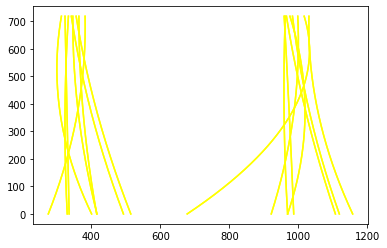

In [15]:
images = glob.glob('./test_images/*.jpg')

# Step through the list and search for chessboard corners

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    undistorted = cal_undistort(img,objpoints,imgpoints)
    binary_img = binary(undistorted)
    binary_warped = warp(binary_img, src, dst)
    leftx, lefty, rightx, righty, ploty = fitpoly_scratch(binary_warped)[5:]
    left_fitx, right_fitx = fitpoly_scratch(binary_warped)[3:5]
    result = drawlines(binary_warped, undistorted, src, dst, left_fitx, right_fitx)
    cv2.imwrite(fname, result)

# Video_pipeline

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Define Line class

In [0]:
# Decide if we calculate sliding window from scratch or use previous one, then plot the average of 5 last polynomial coefficients
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last fit of the line
        self.xfitted = None 
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([False])
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the last n iterations
        self.recent_fit = np.array([False])
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.bad_status = False
        self.bad_count = None


# Reset parameters if sanity checks reveal that the lane lines are problematic
    def reset_params(self, fit, xfitted, x, y):

        self.bad_count = 0
        self.bad_status = False
        self.current_fit = fit.copy()
        self.xfitted = xfitted.copy()
        self.allx = x
        self.ally = y
        
        self.recent_fit = np.array([fit])        
        self.recent_xfitted = np.array([xfitted])
        

    def update_params(self, fit, xfitted, recent_fit, recent_xfitted, best_fit, bestx, bad_status, x, y):

        self.allx = x
        self.ally = y
        
        if best_fit is None:
            self.current_fit = fit.copy()
            self.xfitted = xfitted.copy()
        else:
            self.current_fit = best_fit.copy()
            self.xfitted = bestx.copy()
        
        # Notes: array adjunction, pretty strict with sizes and shapes, please be careful and do not forget to add axis=0
        if bad_status == False:
            self.recent_fit = np.concatenate((recent_fit, [fit]), axis=0)
            self.recent_xfitted = np.concatenate((recent_xfitted, [xfitted]), axis=0)


# Before moving on, check if the detection makes sense
    def slope(self, fit):
        slope = 2*fit[0]+ fit[1]       
        return slope       

#Average up to the last 5 frames. Notes: do not forget to add axis=0 as well   
    def smooth_lines(self, recent_fit, recent_xfitted):

        if len(recent_fit)<5:
            self.best_fit = None
            self.bestx = None
        else:
            self.best_fit = np.average((recent_fit)[-5:], axis=0)
            self.bestx = np.average((recent_xfitted)[-5:], axis=0)


## Define process functions

In [0]:
def sanity_check(bad_count):
    left_line.bad_count = bad_count
    left_slope = left_line.slope(left_line.current_fit)
    right_slope = right_line.slope(right_line.current_fit)
    slope_diff = np.absolute(left_slope - right_slope)
    if slope_diff < 1 and slope_diff >0.001:
        left_line.detected = True
        right_line.detected = True
        left_line.bad_status = False
    else:
        left_line.bad_status = True
        left_line.bad_count += 1

    if left_line.bad_count>2:
        left_line.detected = False
        right_line.detected = False
    
    return left_line.detected, right_line.detected, left_line.bad_status, left_line.bad_count

def drawlines_video(binary_warped, undistorted, src, dst):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Fill the space between polylines
    cv2.fillPoly(color_warp, np.int_([pts]),(0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    # Add curvature & car position to image
    center_curverad, position, left_curverad, right_curverad = measure_curvature(binary_warped, left_line.allx, left_line.ally, right_line.allx, right_line.ally, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255, 255, 255)
    cv2.putText(result, 'Curvature: {} m'.format(center_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} m of center'.format(position), (50, 120), font, fontScale, fontColor, 2)

    return result

def process_image(img):
    undistorted = cal_undistort(img,objpoints,imgpoints)
    binary_img = binary(undistorted)
    binary_warped = warp(binary_img, src, dst)

    if left_line.detected == False or right_line.detected == False:
        out_img, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty = fitpoly_scratch(binary_warped)
        left_line.reset_params(left_fit, left_fitx, leftx, lefty)
        right_line.reset_params(right_fit, right_fitx, rightx, righty)
        left_line.detected, right_line.detected, left_line.bad_status, left_line.bad_count = sanity_check(left_line.bad_count)
    else:
        out_img, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty = fitpoly_prior(binary_warped, left_line.current_fit, right_line.current_fit)
        left_line.update_params(left_fit, left_fitx, left_line.recent_fit, left_line.recent_xfitted, left_line.best_fit, left_line.bestx, left_line.bad_status, leftx, lefty)
        right_line.update_params(right_fit, right_fitx, right_line.recent_fit, right_line.recent_xfitted, right_line.best_fit, right_line.bestx, left_line.bad_status, rightx, righty)
        left_line.detected, right_line.detected, left_line.bad_status, left_line.bad_count = sanity_check(left_line.bad_count)

    left_line.smooth_lines(left_line.recent_fit, left_line.recent_xfitted)
    right_line.smooth_lines(right_line.recent_fit, right_line.recent_xfitted)
    result = drawlines_video(binary_warped, undistorted, src, dst)

    return result

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [24:08<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 24min 34s, sys: 5.15 s, total: 24min 39s
Wall time: 24min 11s


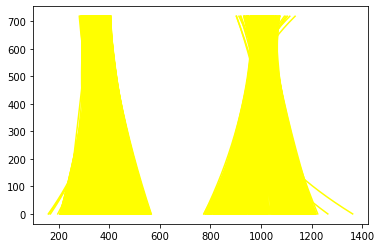

In [18]:
left_line = Line()
right_line = Line()
output = 'project_video_out.mp4'
clip = VideoFileClip("./project_video.mp4")
clip_output = clip.fl_image(process_image) #NOTE: this function expects color images!! Use subclip to tune the parameters
%time clip_output.write_videofile(output, audio=False)

## Side note: when I get no good results, I used online tool to convert the videos to different pcs of images, and process that single image only to verify if my pre-prcess
## functions and parameters are ok